# Basic Setting

In [5]:
import torch
torch.cuda.device_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda

False

In [6]:
out_channels = 10
n_node = 38
num_features = n_node
w1 = 2
w2 = 1

In [21]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset 
EPS = 1e-15
MAX_LOGSTD = 1
 
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        self.w1 = w1
        self.w2 = w2
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).sum()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).sum()
        N1 = len(-torch.log( self.decoder(z, pos_edge_index, sigmoid=True) + EPS))
        N2 = len(-torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + EPS))

        return (self.w1 * pos_loss + self.w2 * neg_loss) / (N1+N2)


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(VGAE, self).__init__(encoder, w1, w2, decoder)
        self.w1 = w1
        self.w2 = w2

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, non_orphan_list=None, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.non_orphan_list = non_orphan_list
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj > 0] = 1
            for i in range(self.n_node):
                adj[i, i] = 0
            for i in range(self.n_node):
                for j in range(self.n_node):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            for i in range(self.n_node - 1, -1, -1):
                if i not in self.non_orphan_list:
                    adj = np.delete(adj, (i), axis=0)
                    adj = np.delete(adj, (i), axis=1)
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(len(self.non_orphan_list))
        x_onehot = torch.eye(len(self.non_orphan_list))[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

def recover_full_matrix(adj_mat, non_orphan_list):
    df = pd.DataFrame(adj_mat, index=non_orphan_list)
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,len(non_orphan_list))), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    df = df.T
    df.index = non_orphan_list
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,38)), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    return np.matrix(df)

def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

import matplotlib.pyplot as plt

def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

def sample_adj_mat(model, filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

def plot_p_value_figure(p_value_table, title_name="p-value of ipfvsctrl.png"):
    import matplotlib.pyplot as plt
    celltype_list = pd.read_csv("./vgae_data/result_all_raw/EGF/Control/EGF.Control.001C.csv")
    celltype_list = np.array(celltype_list.iloc[:,0])
    p_value_table.index = celltype_list
    res_p_value_table = pd.DataFrame()
    for i in range(38):
        res_p_value_table = res_p_value_table.append(np.log10(p_value_table.iloc[i]))
    res_p_value_table = res_p_value_table.T

    fig, ax = plt.subplots(figsize=(15,10), dpi=300)
    for i in range(38):
        if i !=25:
            y = -np.array(res_p_value_table.iloc[:,i])
            x = np.array(res_p_value_table.index)
            if p_value_table.iloc[i,0]<0.05/38:
                ax.plot(x, y, label=celltype_list[i], linestyle="-")
            else:
                ax.plot(x, y, label=celltype_list[i], linestyle="dotted")
        
    for line, name in zip(ax.lines, res_p_value_table.columns):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y), xytext=(6, 0),
                    color=line.get_color(), xycoords=ax.get_yaxis_transform(),
                    textcoords="offset points", size=5, va="center")
    ax.legend(bbox_to_anchor=(-0.05, 1))
    plt.xlabel("generation size")
    plt.ylabel("negative log of p-value")
    plt.title(title_name)
    plt.savefig(title_name, bbox_inches='tight') 

def compute_empirical_p_value(real_stat, empirical_stat):
    p_value = []
    for i in range(real_stat.shape[0]):
        p_value.append(np.sum(real_stat[i] < empirical_stat.iloc[i])/empirical_stat.shape[1])
    return p_value

# Input Test

In [224]:
raw_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
raw_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))

from scipy import stats
raw_ipf_cent_list = []
raw_ctrl_cent_list = []
for i in range(len(raw_ipf_data.get_adj_m())):
    adj_mat = raw_ipf_data.get_adj_m()[i]
    raw_ipf_cent_list.append(compute_cent(adj_mat))
    
for i in range(len(raw_ctrl_data.get_adj_m())):
    adj_mat = raw_ctrl_data.get_adj_m()[i]
    raw_ctrl_cent_list.append(compute_cent(adj_mat))
    
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, 
                      equal_var=True, axis=0)
display(res)
res.pvalue[17]

Ttest_indResult(statistic=array([ -1.22613002,  -2.73267419,  -1.62763213,  -1.92845401,
        -6.44529234,  -5.69335965,  -5.24350011,  -6.05607094,
        -5.44453093,  -3.59767701,  -5.48108529,  -7.70520001,
        -4.17178166,  -6.28418729,  -4.47910071,  -3.96050302,
        -2.60178919,  -4.79646481,  -5.99732566,  -5.52539161,
        -4.34929447,  -5.37844245,  -5.51011443,  -2.12630116,
        -4.87126808, -19.01152631,   1.0614688 ,  -5.38696229,
        -5.22931327,  -4.63609494,  -2.91626105,  -3.61312494,
        -3.65880708,  -3.9572317 ,  -2.82862579,  -3.95609441,
        -2.12429365,  -7.23738612]), pvalue=array([2.25104704e-01, 8.31308666e-03, 1.09023825e-01, 5.86981223e-02,
       2.48756404e-08, 4.34012927e-07, 2.31092749e-06, 1.10139096e-07,
       1.09947451e-06, 6.64933155e-04, 9.59773860e-07, 1.91328661e-10,
       1.02382702e-04, 4.61275440e-08, 3.57332916e-05, 2.07011680e-04,
       1.17506764e-02, 1.16789902e-05, 1.37686764e-07, 8.13765939e-07,
       5

1.1678990174105619e-05

# Train an IPF model

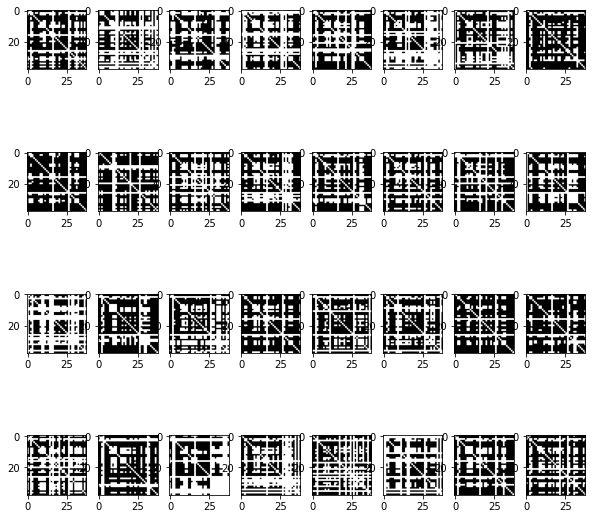

In [5]:
non_orphan_list = range(38)
full_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
full_ipf_input_adj_list = []
full_ipf_input_cent_list = []
n = len(full_ipf_data.get_adj_m())
for i in range(n):
    adj_mat = full_ipf_data.get_adj_m()[i]
    full_ipf_input_adj_list.append(adj_mat)
    full_ipf_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ipf_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]
ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=non_orphan_list)
dataset = ipf_data.graph_dataset()

n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

# non-orphan nodes
ipf_index = range(n)

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
k = 0
for i in ipf_index:
    k += 1
    plt.subplot(4, 8, k)
    plt.imshow(ipf_data.get_adj_m()[i], cmap="Greys")

In [7]:
input_adj_list = []
input_cent_list = []

for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

VGAE_Encoder = Encoder(num_features, out_channels)
model_ipf = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
optimizer = torch.optim.Adam(model_ipf.parameters(), lr=0.005)
epochs = 10000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()

    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model_ipf.encode(train_data.x, train_data.edge_index)
        loss = model_ipf.recon_loss(z, train_data.edge_index) 
        loss = loss + 0.001 * 1/n_node * model_ipf.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("epoch "+str(epoch)+"loss "+str(loss_avg))  
PATH = "./model/best model_ipf"+".pth"
torch.save(model_ipf, PATH)

epoch 0loss tensor(2.3451, grad_fn=<DivBackward0>)
epoch 100loss tensor(0.4976, grad_fn=<DivBackward0>)
epoch 200loss tensor(0.4001, grad_fn=<DivBackward0>)
epoch 300loss tensor(0.3639, grad_fn=<DivBackward0>)
epoch 400loss tensor(0.3453, grad_fn=<DivBackward0>)
epoch 500loss tensor(0.3354, grad_fn=<DivBackward0>)
epoch 600loss tensor(0.3301, grad_fn=<DivBackward0>)
epoch 700loss tensor(0.3220, grad_fn=<DivBackward0>)
epoch 800loss tensor(0.3070, grad_fn=<DivBackward0>)
epoch 900loss tensor(0.2919, grad_fn=<DivBackward0>)
epoch 1000loss tensor(0.2786, grad_fn=<DivBackward0>)
epoch 1100loss tensor(0.2734, grad_fn=<DivBackward0>)
epoch 1200loss tensor(0.2674, grad_fn=<DivBackward0>)
epoch 1300loss tensor(0.2646, grad_fn=<DivBackward0>)
epoch 1400loss tensor(0.2605, grad_fn=<DivBackward0>)
epoch 1500loss tensor(0.2568, grad_fn=<DivBackward0>)
epoch 1600loss tensor(0.2539, grad_fn=<DivBackward0>)
epoch 1700loss tensor(0.2504, grad_fn=<DivBackward0>)
epoch 1800loss tensor(0.2480, grad_fn=<D

In [9]:
import copy

for i in ipf_index:
    PATH = "./model/best model_ipf"+".pth"
    model_ipf = torch.load(PATH)
    mu_list_in_data = []
    logstd_list_in_data = []
    
for i in ipf_index:
    train_data, val_data, test_data = transform(dataset[i])
    mu = model_ipf.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)

for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# Gaussian distribution for generating mu
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

not_significant_num = []
not_sig_num = 0
best_fv = 0
output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 2000

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=False, filter_value=0, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())

for fv in np.linspace(0.5,0.8,30):
    adj_mat_list_temp = []
    output_cent_list_temp = []
    for adj in output_adj_list:
        adj_temp = copy.copy(adj)
        adj_temp[adj_temp < fv] = 0
        adj_temp[adj_temp >= fv] = 1
        adj_mat_list_temp.append(adj_temp)
        output_cent_list+temp.append(compute_cent(adj_temp))

    res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/38)+38-(n_node))
    if (np.sum(res.pvalue>0.05/38)+38-(n_node)) > not_sig_num:
        not_sig_num = np.sum(res.pvalue>0.05/38)+38-(n_node)
        best_fv = fv

# generate adjacency matrices
output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000
print(best_fv, not_sig_num)

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=best_fv, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))

ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

p_value_table = pd.DataFrame()
for gen_size in range(100, 2100, 100):
    res = stats.ttest_ind(output_cent_list[0:gen_size], input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)
p_value_table.columns = range(100, 2100, 100)

0.7586206896551724 32


In [10]:
# recover to sparse matrices
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

full_ipf_output_adj_list = []
full_ipf_output_cent_list = []

for i in range(gen_size):
    full_ipf_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ipf_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

np.save("./model/full_ipf_output_cent"+".npy", full_ipf_output_cent_list)
np.save("./model/full_ipf_output_adj"+".npy", full_ipf_output_adj_list)

# Train Ctrl model

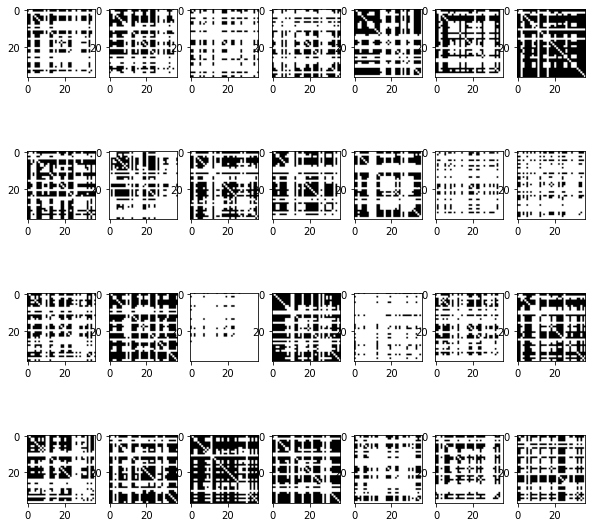

In [11]:
full_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))
full_ctrl_input_adj_list = []
full_ctrl_input_cent_list = []
n = len(full_ctrl_data.get_adj_m())

for i in range(n):
    adj_mat = full_ctrl_data.get_adj_m()[i]
    full_ctrl_input_adj_list.append(adj_mat)
    full_ctrl_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ctrl_input_cent_list, axis=0)
non_orphan_list = np.argwhere(mean_input_cent != 0).T[0]
ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=non_orphan_list)
dataset = ctrl_data.graph_dataset()

n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

# non-orphan nodes
ctrl_index = range(n)

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 7, figsize=(10,10))
k = 0
for i in ctrl_index:
    k += 1
    plt.subplot(4, 7, k)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

In [27]:
input_adj_list = []
input_cent_list = []

for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

out_channels = 10
n_node = 37
num_features = n_node
w1 = 2
w2 = 1

VGAE_Encoder = Encoder(num_features, out_channels)
model_ctrl = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=0.005)
epochs = 5000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()

    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model_ctrl.encode(train_data.x, train_data.edge_index)
        loss = model_ctrl.recon_loss(z, train_data.edge_index) 
        loss = loss + 0.001 * 1/n_node * model_ctrl.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("epoch "+str(epoch)+"loss "+str(loss_avg))  
PATH = "./model/best model_ctrl_2"+".pth"
torch.save(model_ctrl, PATH)

epoch 0loss tensor(2.0472, grad_fn=<DivBackward0>)
epoch 1000loss tensor(0.3251, grad_fn=<DivBackward0>)
epoch 2000loss tensor(0.3005, grad_fn=<DivBackward0>)
epoch 3000loss tensor(0.2771, grad_fn=<DivBackward0>)
epoch 4000loss tensor(0.2654, grad_fn=<DivBackward0>)


In [38]:
np.mean(input_cent_list, axis=0)

array([0.64189189, 0.62741313, 0.20849421, 0.2992278 , 0.44980695,
       0.63610039, 0.53571429, 0.50675676, 0.25772201, 0.26061776,
       0.16602317, 0.06081081, 0.61583012, 0.43532819, 0.30405405,
       0.26833977, 0.06177606, 0.3503861 , 0.55984556, 0.51158301,
       0.28088803, 0.24517375, 0.55984556, 0.51640927, 0.50675676,
       0.17953668, 0.27316602, 0.16216216, 0.28764479, 0.246139  ,
       0.1969112 , 0.26158301, 0.51351351, 0.42277992, 0.50289575,
       0.35135135, 0.23552124])

In [40]:
import copy

PATH = "./model/best model_ctrl"+".pth"
#model_ctrl = torch.load(PATH)
mu_list_in_data = []
logstd_list_in_data = []
    
for i in ctrl_index:
    train_data, val_data, test_data = transform(dataset[i])
    mu = model_ctrl.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)

for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# Gaussian distribution for generating mu
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

not_significant_num = []
not_sig_num = 0
best_fv = 0
output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 200

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=False, filter_value=0, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())

for fv in np.linspace(0.5,0.8, 100):
    adj_mat_list_temp = []
    output_cent_list_temp = []
    for adj in output_adj_list:
        adj_temp = copy.copy(adj)
        adj_temp[adj_temp < fv] = 0
        adj_temp[adj_temp >= fv] = 1
        adj_mat_list_temp.append(adj_temp)
        output_cent_list_temp.append(compute_cent(adj_temp))

    res = stats.ttest_ind(output_cent_list_temp, ctrl_input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/38))
    if (np.sum(res.pvalue>0.05/38)) > not_sig_num:
        not_sig_num = np.sum(res.pvalue>0.05/38)
        best_fv = fv
        

# generate adjacency matrices
output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000
print(best_fv, not_sig_num)

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=True, filter_value=best_fv, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))

ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

p_value_table = pd.DataFrame()
for gen_size in range(100, 2100, 100):
    res = stats.ttest_ind(output_cent_list[0:gen_size], input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)
p_value_table.columns = range(100, 2100, 100)

0.7424242424242424 37


In [44]:
# recover to sparse matrices
ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

full_ctrl_output_adj_list = []
full_ctrl_output_cent_list = []

for i in range(gen_size):
    full_ctrl_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ctrl_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

np.save("./model/full_ctrl_output_cent"+".npy", full_ctrl_output_cent_list)
np.save("./model/full_ctrl_output_adj"+".npy", full_ctrl_output_adj_list)

# IPF output vs. Ctrl output

In [47]:
full_ipf_output_cent_list = np.load('./model/full_ipf_output_cent.npy').tolist()
full_ctrl_output_cent_list = np.load('./model/full_ctrl_output_cent.npy').tolist()
p_value_table = pd.DataFrame()
for k in range(100, 2100, 100):
    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], 
                      equal_var=True, axis=0)
    for i in range(len(res.pvalue)):
        res.pvalue[i] = res.pvalue[i]
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

/tmp/ipykernel_19900/1700200591.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(np.log10(df.iloc[i]))
/tmp/ipykernel_19900/1700200591.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(np.log10(df.iloc[i]))
/tmp/ipykernel_19900/1700200591.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(np.log10(df.iloc[i]))
/tmp/ipykernel_19900/1700200591.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(np.log10(df.iloc[i]))
/tmp/ipykernel_19900/1700200591.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

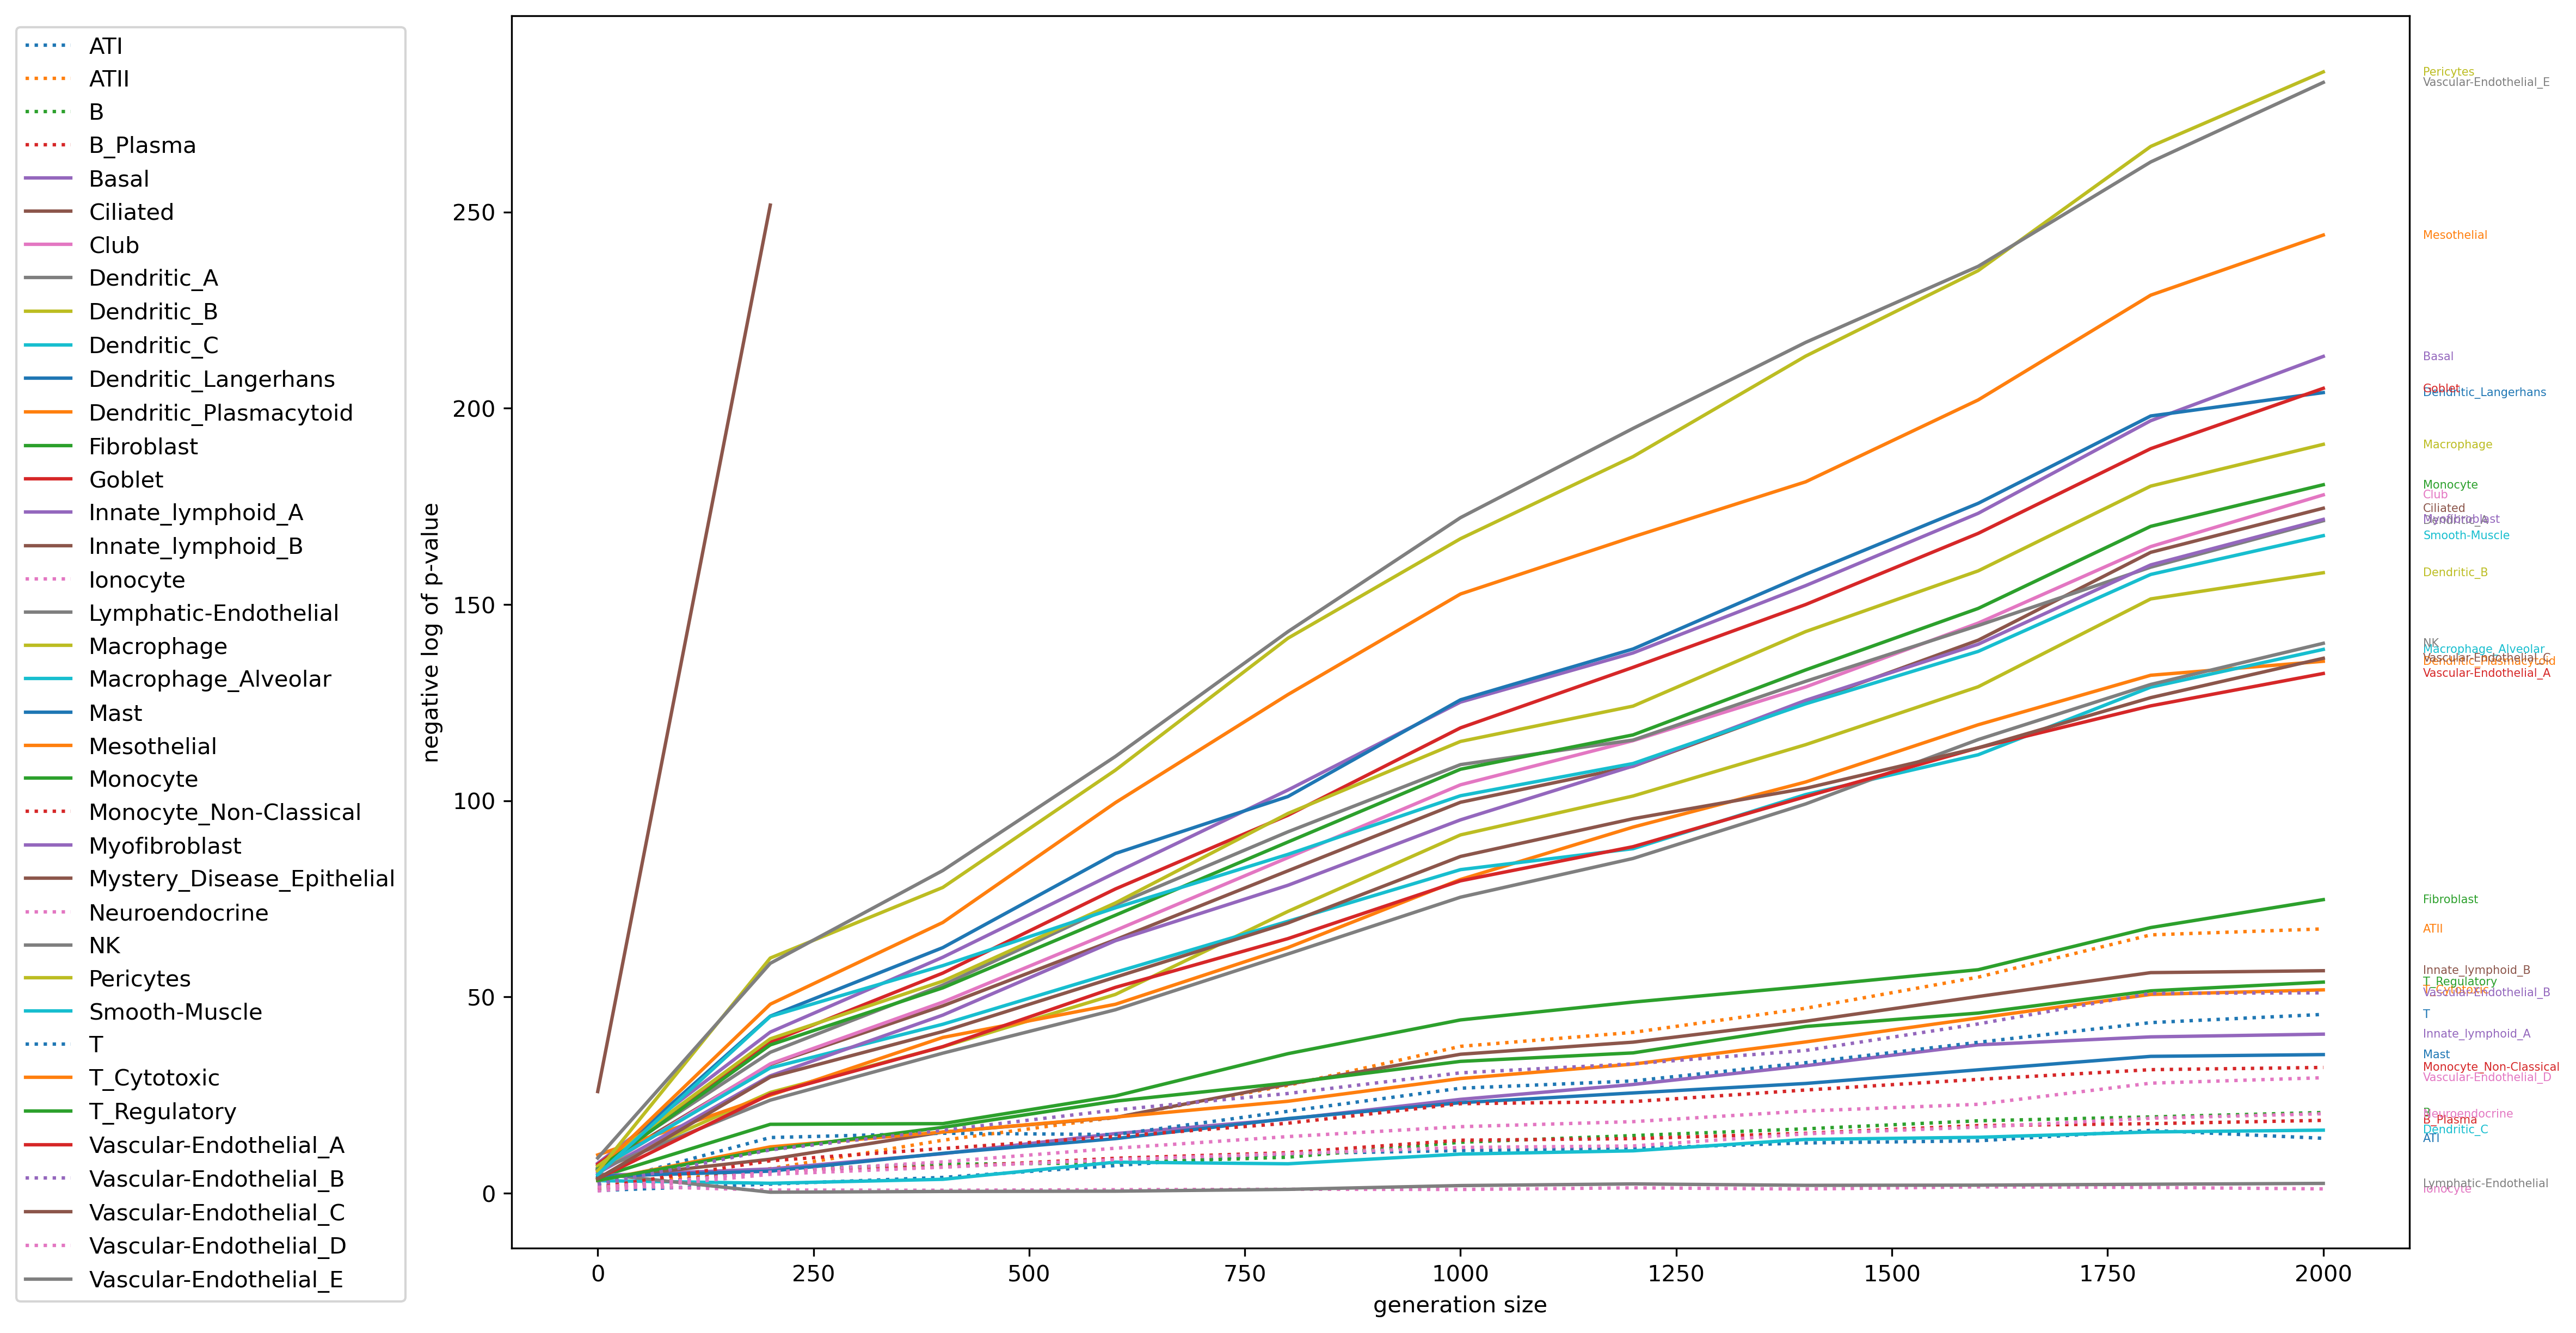

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("./figures/EGF data analysis.xlsx", sheet_name="ctrl_vs_ipf", index_col="node")
celltype_list = pd.read_csv("./vgae_data/result_all_raw/EGF/Control/EGF.Control.001C.csv")
celltype_list = np.array(celltype_list.iloc[:,0])
df = df.rename(columns={"Original":0})
df.index = celltype_list
res_df = pd.DataFrame()
for i in range(38):
    res_df = res_df.append(np.log10(df.iloc[i]))
res_df = res_df.T

fig, ax = plt.subplots(figsize=(15,10), dpi=300)
for i in range(38):
    y = -np.array(res_df.iloc[:,i])
    x = np.array(res_df.index)
    if df.iloc[i,0]<0.05/38:
        ax.plot(x, y, label=celltype_list[i], linestyle="-")
    else:
        ax.plot(x, y, label=celltype_list[i], linestyle="dotted")
    
for line, name in zip(ax.lines, res_df.columns):
      y = line.get_ydata()[-1]
      ax.annotate(name, xy=(1, y), xytext=(6, 0),
                  color=line.get_color(), xycoords=ax.get_yaxis_transform(),
                  textcoords="offset points", size=5, va="center")

ax.legend(bbox_to_anchor=(-0.05, 1))
plt.xlabel("generation size")
plt.ylabel("negative log of p-value")
plt.savefig('ipfvsctrl.png', bbox_inches='tight')
plt.show()

# Spectrum test

In [ ]:
def compute_spectrum_distance(lam1, lam2):
    return linalg.norm((lam1-lam2), 2)

def compute_wald_stat(G0_adj_list, G1_adj_list):
    n0 = len(G0_adj_list)
    n1 = len(G1_adj_list)
    G_adj_list = G0_adj_list + G1_adj_list
    n = len(G_adj_list)
    import numpy.linalg as linalg
    G0_spectrum = []
    G1_spectrum = []

    for i in range(len(G0_adj_list)):
        G0_adj_list[i] = np.array(G0_adj_list[i])
    for i in range(len(G1_adj_list)):
        G1_adj_list[i] = np.array(G1_adj_list[i])

    for adj in G0_adj_list:
        lam, v = linalg.eig(adj)
        G0_spectrum.append(lam)
    for adj in G1_adj_list:
        lam, v = linalg.eig(adj)
        G1_spectrum.append(lam) 

    spectrum_distance_matrix = np.empty((len(G0_adj_list), len(G1_adj_list)))
    for i in range((len(G0_adj_list))):
        for j in range(len(G1_adj_list)):
            spectrum_distance_matrix[i, j] = compute_spectrum_distance(G0_spectrum[i], G1_spectrum[j])
    spectrum_distance_matrix_G0_G1 = spectrum_distance_matrix
    
    G_spectrum = []
    
    for adj in G_adj_list:
        lam, v = linalg.eig(adj)
        G_spectrum.append(lam)

    spectrum_distance_matrix_G = np.empty((len(G_adj_list), len(G_adj_list)))

    for i in range((len(G_adj_list))):
        for j in range(len(G_adj_list)):
            spectrum_distance_matrix_G[i, j] = compute_spectrum_distance(G_spectrum[i], G_spectrum[j])

    spectrum_mat_G_copy = copy.copy(spectrum_distance_matrix_G)
    np.fill_diagonal(spectrum_mat_G_copy, 0)

    mean_dis_G = np.sum(spectrum_mat_G_copy) / ((n-1)*n)
    mean_dis_G0_G1 = np.mean(spectrum_distance_matrix_G0_G1)
    mean_dis_G = np.mean(spectrum_mat_G_copy[~np.eye(spectrum_mat_G_copy.shape[0],dtype=bool)].reshape(spectrum_mat_G_copy.shape[0],-1).flatten())
    var_dis_G = np.var(spectrum_mat_G_copy[~np.eye(spectrum_mat_G_copy.shape[0],dtype=bool)].reshape(spectrum_mat_G_copy.shape[0],-1).flatten())
    var_dis_G0_G1 = np.var(spectrum_distance_matrix_G0_G1.flatten())
    W_stat_alt = (mean_dis_G0_G1 - mean_dis_G) ** 2 / (1 / (n0*n1) * var_dis_G)
    W_stat = (mean_dis_G0_G1 - mean_dis_G) ** 2 / (1 / (n0*n1) * var_dis_G0_G1)
    
    return W_stat

In [ ]:
compute_wald_stat(full_ipf_input_adj_list, full_ctrl_input_adj_list)

In [ ]:
compute_wald_stat(full_ipf_output_adj_list, full_ctrl_output_adj_list)

In [ ]:
spectrum_test_w_value = []
spectrum_test_p_value = []
for k in range(100, 2000, 10):
    spectrum_test_p_value.append(np.log10(1 - stats.chi2.cdf(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]), 1)))
    spectrum_test_w_value.append(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(100, 2000, 10), np.log10(spectrum_test_w_value))
plt.hlines(np.log10(33.92), 0, 2000, color='r')
plt.ylabel("log10 of W-statistic")
plt.xlabel("sample size of each group")
plt.title("log10 of W statistics vs. sample size")

# Permutation

In [206]:
input_t_stat_table = pd.DataFrame()
whole_input_cent_list = full_ctrl_input_cent_list + full_ipf_input_cent_list
per_times = 20
for per_time in range(per_times):
    random.shuffle(whole_input_cent_list)
    res = stats.ttest_ind(whole_input_cent_list[0:28], whole_input_cent_list[28:60], equal_var=True, axis=0)
    input_t_stat_table = pd.concat([input_t_stat_table, pd.DataFrame(res.statistic)], axis=1)
input_t_stat_table
#.to_csv("./model/input_t_stat_permutation.csv", index=False)

0         0         0         0         0         0         0  \
0  -0.287875 -0.013303  0.086473  0.967160 -0.212926  0.336219 -1.226130   
1  -1.363301 -0.448096  0.645331 -0.055917 -0.958053  1.275622 -1.334017   
2  -0.297675 -1.446815  0.315884 -0.059037 -0.161248  0.077204  1.322837   
3  -0.182273 -0.013498  0.869473 -0.554878 -0.691219  1.935865 -0.828223   
4  -1.376188 -1.333489  1.018220  0.153523 -0.705262  1.528101 -1.483499   
5  -0.961706 -0.471771  0.347316 -0.247957 -0.247957  0.721916 -0.999808   
6  -1.367799 -0.710596  0.497305  0.004913 -0.636029  1.300961 -1.733421   
7  -1.857111 -0.693509  0.661639  0.254355 -0.523155  0.729977 -1.141964   
8  -1.500278 -1.054823  0.269595 -0.487276 -1.224666  1.238328 -0.819555   
9  -1.973370 -0.599961  1.281100  0.997147  0.624610  0.195365  0.593801   
10 -1.097636 -0.796217  0.633740  0.807862  1.058867 -0.006545 -1.797090   
11 -1.897216 -1.138348  0.775949  0.249506  0.497971  0.831880 -0.884202   
12 -1.601141 -0.553145  0.464364 -0.802213 -0.739738  0.650443 -1.568358   
13 -1.264857 -0.401422 -0.550506 -0.210394 -1.375529  1.114114 -0.721671   
14 -1.162772 -1.162772 -0.560012  0.067208 -0.595074  1.014657 -0.524985   
15 -0.652693 -0.272885  0.262377 -0.589131 -0.844249  1.925783 -0.684524   
16  0.473632 -0.039394 -1.278215 -0.772105 -1.381237  1.094443  0.019697   
17 -1.175382 -0.999723 -0.011361  0.629820 -0.566757  0.976425 -1.219575   
18 -1.705134 -0.346325  0.769976 -0.140058 -0.181272  0.395925 -1.226488   
19 -1.003272 -1.312914  1.188377 -0.812290 -0.850354  0.539823 -0.774285   
20 -0.885752 -0.820159  1.061662  0.053649 -0.754746  0.537813 -0.918621   
21 -0.686045 -0.412831  0.282540  0.985056  0.708917  0.384480 -0.823578   
22 -1.910591 -0.691069  0.639604 -0.488394 -0.731766  0.843332 -0.977381   
23 -1.717489  0.153573  0.835923 -0.971973 -1.146268  0.153573 -1.681059   
24 -0.592671 -1.042517  0.200132  0.363318 -0.125638  1.582418 -1.752123   
25 -0.976459 -1.107497 -0.092400  0.642653  0.082840  1.146991  0.417988   
26  0.839683  0.377650  0.401820  0.962602 -0.080257  0.426003 -0.008025   
27 -0.964219 -0.023331  0.856966 -1.572341 -0.315242  1.277492 -0.315242   
28 -0.538104 -0.501908  0.542933 -0.267349  0.110240  0.815779 -0.231347   
29 -0.884817 -0.375172  1.621566 -0.676144  0.806200  0.279046 -0.581817   
30 -0.841888 -0.685541  0.473210 -0.336585 -0.491286 -0.724540 -1.851784   
31 -0.043818 -0.904566  0.648643 -0.971794  0.516032  0.549137 -0.704064   
32 -0.273654 -0.763990  0.986195 -0.169227 -0.030129  0.844111  0.492358   
33 -1.169298 -0.863936  0.445988  0.285327 -0.724459  0.056417 -1.051274   
34 -0.318152  0.711258  0.772475 -0.887155  0.406976 -0.277822  0.044262   
35 -1.270497 -0.471776  0.087922  0.898767 -0.697294  0.967338 -0.993302   
36 -1.577326 -0.467836  1.395220 -0.449156  0.444176 -0.692754  0.857549   
37 -1.085876 -0.789541  1.339883 -1.366860 -1.225758  0.607011  0.999827   

           0         0         0         0         0         0         0  \
0   0.763726  0.738418 -1.540427  0.086473  0.814416 -1.382424  0.011640   
1  -0.027958 -0.307786 -2.149709 -0.307786 -0.448096 -0.476209  0.391925   
2   1.322837  1.216369 -0.400176  0.658652 -1.664105  0.179427 -0.400176   
3  -1.209531  0.391955 -0.966026  0.358088 -0.182273  0.020247  0.391955   
4  -1.079696  0.378081 -0.912486 -0.725907 -0.356272 -0.233743 -1.269666   
5  -0.024783 -0.285199 -1.268768 -0.772198  0.421950  0.571602 -0.923674   
6  -0.660863 -0.265482 -1.213994 -0.388660  0.201518  0.645960 -0.910495   
7   0.593459  0.457508 -1.282111 -1.072322  1.005252 -0.218308 -0.285910   
8   0.599847  0.368427 -1.122562 -1.396310  0.467446  0.039429 -1.088661   
9   0.073241  0.378863 -1.512009  1.473260  0.748167  0.563021  0.593801   
10 -0.523165  1.416243 -0.547890 -0.646969 -0.129275 -0.153830 -0.622170   
11  0.692283  1.313651 -0.716426  0.332200  1.028750 -0.300948 -0.549678   
12 -0.121018 -0.090246 -2.490029 -0.121018  0.402537 -0.24

In [197]:
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, equal_var=True, axis=0)
input_t_stat = res.statistic

In [ ]:
import os
t_stat_table = input_t_stat
per_t_stat = pd.read_csv("./model/input_t_stat_permutation.csv")
for i in range(38):
    x = np.linspace(t.ppf(0.01, df=58), t.ppf(0.99, df=2*gen_size-2), 100)
    plt.plot(x, t.pdf(x, df=58), 'r-', lw=1, label='t pdf, df='+str(58))
    plt.hist(per_t_stat.iloc[i], bins=30, alpha=0.5, density=True, facecolor="b", label="t-stat from permutation labels")
    plt.vlines(input_t_stat[i], ymin=0, ymax=0.5, label="t-stat from real t-test")
    plt.xlabel('t-statistics')
    plt.ylabel('Frequency')
    plt.title("celltype="+str(celltype_list[i]))
    plt.legend()
    plt.
    plt.show()

In [143]:
import numpy as np
import pandas as pd
from scipy import stats

t_stat_table = pd.DataFrame()
p_value_table = pd.DataFrame()
for k in range(100, 2100, 100):

    full_ipf_output_cent_list = np.load('./model/full_ipf_output_cent.npy').tolist()
    full_ctrl_output_cent_list = np.load('./model/full_ctrl_output_cent.npy').tolist()

    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue).T], axis=1)
    t_stat_table = pd.concat([t_stat_table, pd.DataFrame(res.statistic).T], axis=1)
t_stat_table.columns = range(100,2100,100)
p_value_table.columns = range(100,2100,100)
p_value_table.to_csv("./model/output_p_value_table.csv", index=False)
t_stat_table.to_csv("./model/ttest_stat.csv", index=False)

In [216]:
import random
per_times = 2000
whole_output_cent_list = full_ipf_output_cent_list + full_ctrl_output_cent_list
for gen_size in range(100, 2100, 100):
    t_stat_table = pd.DataFrame()
    for per_time in range(per_times):
        random.shuffle(whole_output_cent_list)
        res = stats.ttest_ind(whole_output_cent_list[0:gen_size], whole_output_cent_list[gen_size:gen_size*2], equal_var=True, axis=0)
        t_stat_table = pd.concat([t_stat_table, pd.DataFrame(res.statistic).T], axis=1)
    t_stat_table.to_csv("./model/ttest_stat_permutation_"+str(gen_size)+".csv", index=False)

In [217]:
def compute_percentile(num, array):
    return len(array[array<=num])/len(array)

In [ ]:
import os
t_stat_table = pd.read_csv("./model/ttest_stat.csv")
t_stat_table.columns = range(100, 2100, 100)
for gen_size in range(2000, 2100, 100):
    per_t_stat = pd.read_csv("./model/ttest_stat_permutation_"+str(gen_size)+".csv")
    for i in range(38):
        x = np.linspace(t.ppf(0.01, df=2*gen_size-2), t.ppf(0.99, df=2*gen_size-2), 100)
        plt.plot(x, t.pdf(x, df=2*gen_size-2), 'r-', lw=1, label='t pdf, df='+str(2*gen_size-2))
        plt.hist(per_t_stat.iloc[i], bins=30, alpha=0.5, density=True, facecolor="b", label="t-stat from permutation labels")
        plt.vlines(t_stat_table.iloc[i,int(gen_size/100-1)], ymin=0, ymax=0.5, label="t-stat from real t-test")
        plt.xlabel('t-statistics')
        plt.ylabel('Frequency')
        percentile = compute_percentile(t_stat_table.iloc[i,int(gen_size/100-1)], per_t_stat.iloc[i])
        plt.title("celltype="+str(celltype_list[i])+" , "+"generated size="+str(gen_size)+" , percentile in emperical dist="+str(percentile))
        plt.legend()

        path = './permutation figures/'+str(gen_size)

        # Check whether the specified path exists or not
        isExist = os.path.exists(path)

        if not isExist:
          # Create a new directory because it does not exist 
          os.makedirs(path)
        #plt.savefig(path + "/permutation results, celltype="+str(celltype_list[i])+", "+"generated size="+str(gen_size)+".png")
        plt.show()

In [227]:
for gen_size in range(100, 2100, 100):
    per_t_stat = pd.read_csv("./model/ttest_stat_permutation_"+str(gen_size)+".csv")
    for i in range(38):
        percentile = compute_percentile(t_stat_table.iloc[i,int(gen_size/100-1)], per_t_stat.iloc[i])
        emperical_p_value_table.iloc[i, int(gen_size/100-1)] = percentile

<AxesSubplot:>

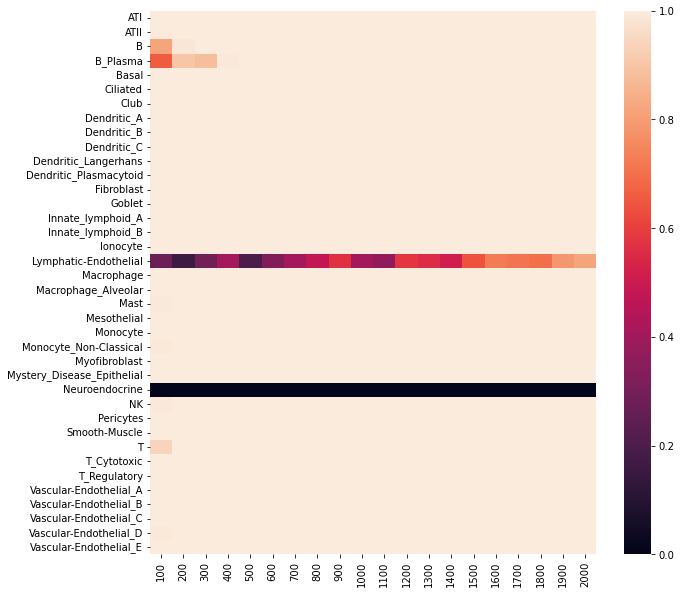

In [233]:
import seaborn as sns
plt.figure(figsize=(10,10))
emperical_p_value_table.index = celltype_list
sns.heatmap(emperical_p_value_table)

In [226]:
emperical_p_value_table

100     200     300     400     500    600   \
ATI                         0.0005  0.0000  0.0000  0.0000  0.0000  0.000   
ATII                        0.0005  0.0000  0.0000  0.0000  0.0000  0.000   
B                           0.1800  0.0135  0.0025  0.0000  0.0000  0.000   
B_Plasma                    0.3400  0.0980  0.1175  0.0050  0.0005  0.000   
Basal                       0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Ciliated                    0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Club                        0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Dendritic_A                 0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Dendritic_B                 0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Dendritic_C                 0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Dendritic_Langerhans        0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Dendritic_Plasmacytoid      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Fibroblast                  0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Goblet                      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Innate_lymphoid_A           0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Innate_lymphoid_B           0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Ionocyte                    0.0020  0.0000  0.0000  0.0000  0.0000  0.000   
Lymphatic-Endothelial       0.7265  0.8370  0.7075  0.5905  0.8035  0.674   
Macrophage                  0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Macrophage_Alveolar         0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Mast                        0.0040  0.0000  0.0000  0.0000  0.0000  0.000   
Mesothelial                 0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Monocyte                    0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Monocyte_Non-Classical      0.0115  0.0000  0.0000  0.0000  0.0000  0.000   
Myofibroblast               0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Mystery_Disease_Epithelial  0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Neuroendocrine              0.9970  1.0000  1.0000  1.0000  1.0000  1.000   
NK                          0.0055  0.0000  0.0000  0.0000  0.0000  0.000   
Pericytes                   0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Smooth-Muscle               0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
T                           0.0610  0.0000  0.0000  0.0000  0.0000  0.000   
T_Cytotoxic                 0.0005  0.0000  0.0000  0.0000  0.0000  0.000   
T_Regulatory                0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Vascular-Endothelial_A      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Vascular-Endothelial_B      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Vascular-Endothelial_C      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
Vascular-Endothelial_D      0.0095  0.0000  0.0000  0.0005  0.0000  0.000   
Vascular-Endothelial_E      0.0000  0.0000  0.0000  0.0000  0.0000  0.000   

                            700    800     900   1000    1100  1200   1300  \
ATI                         0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
ATII                        0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
B                           0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
B_Plasma                    0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Basal                       0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Ciliated                    0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Club                        0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Dendritic_A                 0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Dendritic_B                 0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Dendritic_C                 0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Dendritic_Langerhans        0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Dendritic_Plasmacytoid      0.00  0.000  0.0000  0.00  0.0000  0.00  0.000   
Fibroblast  

/tmp/ipykernel_19900/3963406207.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_p_value_table = res_p_value_table.append(np.log10(p_value_table.iloc[i]))
/tmp/ipykernel_19900/3963406207.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_p_value_table = res_p_value_table.append(np.log10(p_value_table.iloc[i]))
/tmp/ipykernel_19900/3963406207.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_p_value_table = res_p_value_table.append(np.log10(p_value_table.iloc[i]))
/tmp/ipykernel_19900/3963406207.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_p_value_table = res_p_value_table.append(np.log10(p_value_table.il

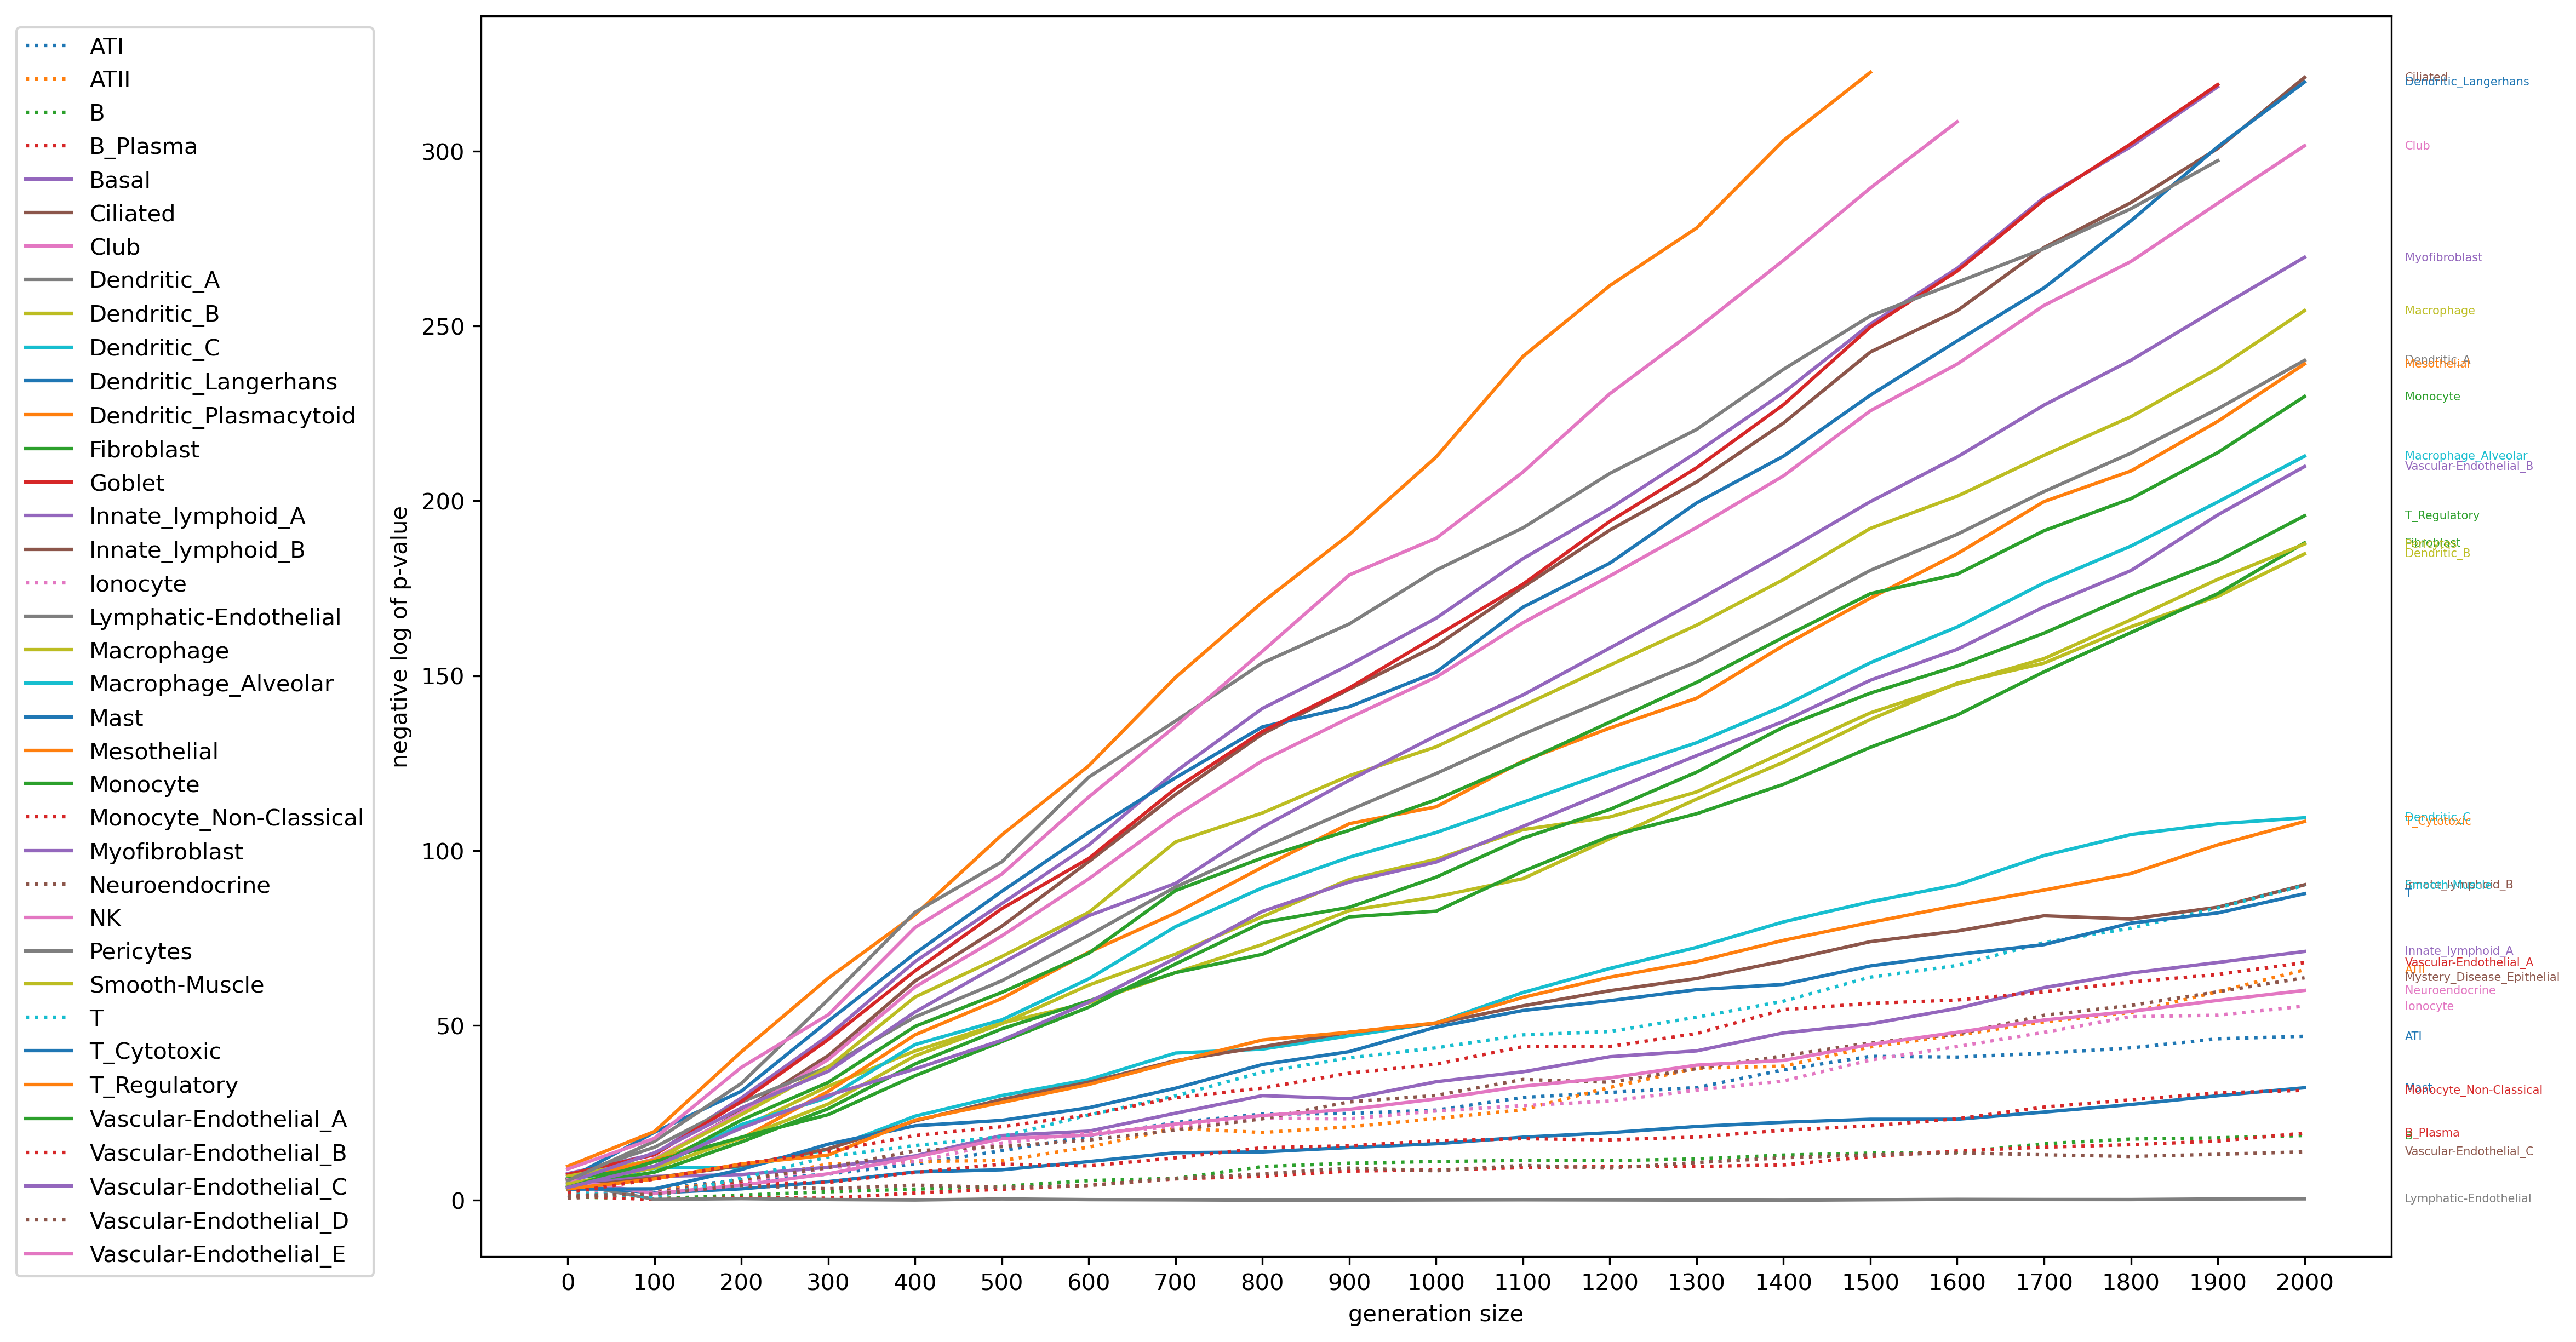

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
p_value_table = pd.read_csv("./model/output_p_value_table.csv")
celltype_list = pd.read_csv("./vgae_data/result_all_raw/EGF/Control/EGF.Control.001C.csv")
celltype_list = np.array(celltype_list.iloc[:,0])
p_value_table.index = celltype_list
res_p_value_table = pd.DataFrame()
for i in range(38):
    res_p_value_table = res_p_value_table.append(np.log10(p_value_table.iloc[i]))
res_p_value_table = res_p_value_table.T

fig, ax = plt.subplots(figsize=(15,10), dpi=300)
for i in range(38):
    if i !=25:
        y = -np.array(res_p_value_table.iloc[:,i])
        x = np.array(res_p_value_table.index)
        if p_value_table.iloc[i,0]<0.05/38:
            ax.plot(x, y, label=celltype_list[i], linestyle="-")
        else:
            ax.plot(x, y, label=celltype_list[i], linestyle="dotted")
    
for line, name in zip(ax.lines, res_p_value_table.columns):
      y = line.get_ydata()[-1]
      ax.annotate(name, xy=(1, y), xytext=(6, 0),
                  color=line.get_color(), xycoords=ax.get_yaxis_transform(),
                  textcoords="offset points", size=5, va="center")

ax.legend(bbox_to_anchor=(-0.05, 1))
plt.xlabel("generation size")
plt.ylabel("negative log of p-value")
plt.savefig('ipfvsctrl.png', bbox_inches='tight')
plt.show()

In [155]:
p_value_table.iloc[:, 0]= np.array(df.iloc[:,0])
p_value_table.to_csv("./model/output_p_value_table.csv", index=False)

In [158]:
p_value_table.to_csv("./model/output_p_value_table.csv", index=False)

# Bootstrap and permutation test

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import random

per_times = 10000000
i = np.random.randint(low=0, high=99)
j = np.random.randint(low=0, high=99)

for k in range(150):
    empirical_p_value_list = []
    while i == j:
        i = np.random.randint(low=0, high=99)
        j = np.random.randint(low=0, high=99)
    if i != j:
        full_ipf_output_cent_list = np.load('./bootstrap data/bs_output_cent)'+str(i)+'.npy').tolist()
        full_ctrl_output_cent_list = np.load('./bootstrap data/bs_output_cent)'+str(j)+'.npy').tolist()
        whole_input_cent_list = full_ipf_output_cent_list + full_ctrl_output_cent_list
    for gen_size in range(100, 1001, 100):
        ## t-statistics in bootstrap k
        empirical_p_value_table_in_k = pd.DataFrame()
        res = stats.ttest_ind(full_ipf_output_cent_list[0:gen_size], full_ctrl_output_cent_list[0:gen_size], equal_var=True, axis=0)
        bs_t_stat = res.statistic
        # bs_p_value = res.pvalue
        t_stat_table = pd.DataFrame()
        # p_value_table = pd.DataFrame()
        for per_time in range(per_times):
            random.shuffle(whole_input_cent_list)
            per_ipf_output_cent_list = whole_input_cent_list[0:gen_size]
            per_ctrl_output_cent_list = whole_input_cent_list[gen_size:gen_size*2]
            res = stats.ttest_ind(per_ipf_output_cent_list, per_ctrl_output_cent_list, equal_var=True, axis=0)
            per_t_stat = res.statistic 
            # per_p_value = res.pvalue
            t_stat_table = pd.concat([t_stat_table, pd.DataFrame(res.statistic).T], axis=1)
        t_stat_table.to_csv("./bootstrap data/t_stat_permutation_gen_size_"+str(gen_size)+" "+"bs_"+str(k)+".csv", index=False)
        empirical_p_value_table_in_k = pd.concat([empirical_p_value_table_in_k, pd.DataFrame(compute_empirical_p_value(bs_t_stat, t_stat_table)).T], axis=1)
    empirical_p_value_list.append(empirical_p_value_table_in_k)

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import random

per_times = 100000000
i = np.random.randint(low=0, high=99)
j = np.random.randint(low=0, high=99)
for k in range(1):
        while i == j:
            i = np.random.randint(low=0, high=99)
            j = np.random.randint(low=0, high=99)
        if i != j:
            full_ipf_output_cent_list = np.load('./bootstrap data/bs_output_cent'+str(i)+'.npy').tolist()
            full_ctrl_output_cent_list = np.load('./bootstrap data/bs_output_cent'+str(j)+'.npy').tolist()
            whole_input_cent_list = full_ipf_output_cent_list + full_ctrl_output_cent_list
        for gen_size in [100]:
            ## t-statistics in bootstrap k
            res = stats.ttest_ind(full_ipf_output_cent_list[0:gen_size], full_ctrl_output_cent_list[0:gen_size], equal_var=True, axis=0)
            bs_t_stat = res.statistic
            # bs_p_value = res.pvalue
            t_stat_table = pd.DataFrame()
            # p_value_table = pd.DataFrame()
            for per_time in range(per_times):
                random.shuffle(whole_input_cent_list)
                per_ipf_output_cent_list = whole_input_cent_list[0:gen_size]
                per_ctrl_output_cent_list = whole_input_cent_list[gen_size:gen_size*2]
                res = stats.ttest_ind(per_ipf_output_cent_list, per_ctrl_output_cent_list, equal_var=True, axis=0)
                per_t_stat = res.statistic 
                # per_p_value = res.pvalue
                t_stat_table = pd.concat([t_stat_table, pd.DataFrame(res.statistic)], axis=1)

In [22]:
compute_empirical_p_value(bs_t_stat, t_stat_table)

[0.0,
 0.05,
 0.0,
 1.0,
 0.71,
 1.0,
 0.86,
 0.53,
 0.0,
 0.0,
 0.07,
 0.99,
 0.89,
 0.59,
 0.03,
 0.0,
 0.89,
 0.72,
 0.49,
 0.56,
 0.01,
 0.01,
 0.5,
 0.0,
 0.06,
 0.0,
 0.06,
 0.06,
 0.0,
 0.25,
 0.0,
 0.7,
 0.04,
 0.74,
 0.09,
 0.99,
 0.13,
 0.15]

In [20]:
t_stat_table.iloc[0]

0    1.012157
0    1.443306
0   -0.331695
0   -0.117212
0   -0.141104
       ...   
0   -1.113102
0    1.317464
0   -0.872551
0   -0.028743
0    0.798822
Name: 0, Length: 100, dtype: float64

In [ ]:
import os
t_stat_table = pd.read_csv("./model/ttest_stat.csv")
t_stat_table.columns = range(100, 2100, 100)
for gen_size in range(2000, 2100, 100):
    per_t_stat = pd.read_csv("./model/ttest_stat_permutation_"+str(gen_size)+".csv")
    for i in range(38):
        x = np.linspace(t.ppf(0.01, df=2*gen_size-2), t.ppf(0.99, df=2*gen_size-2), 100)
        plt.plot(x, t.pdf(x, df=2*gen_size-2), 'r-', lw=1, label='t pdf, df='+str(2*gen_size-2))
        plt.hist(per_t_stat.iloc[i], bins=30, alpha=0.5, density=True, facecolor="b", label="t-stat from permutation labels")
        plt.vlines(t_stat_table.iloc[i,int(gen_size/100-1)], ymin=0, ymax=0.5, label="t-stat from real t-test")
        plt.xlabel('t-statistics')
        plt.ylabel('Frequency')
        percentile = compute_percentile(t_stat_table.iloc[i,int(gen_size/100-1)], per_t_stat.iloc[i])
        plt.title("celltype="+str(celltype_list[i])+" , "+"generated size="+str(gen_size)+" , percentile in emperical dist="+str(percentile))
        plt.legend()

        path = './permutation figures/'+str(gen_size)

        # Check whether the specified path exists or not
        isExist = os.path.exists(path)

        if not isExist:
          # Create a new directory because it does not exist 
          os.makedirs(path)
        plt.savefig(path + "/permutation results, celltype="+str(celltype_list[i])+", "+"generated size="+str(gen_size)+".png")
        plt.show()